In [20]:

import pandas as pd
import pickle
import networkx as nx
import sys
import os

sys.path.append(os.path.abspath('..'))
from src.features import get_pagerank, get_approx_betweenness, get_clustering_coefficient

# 1. Load the graph from the pickle file
# Make sure the path is correct relative to where you run this script
with open("../data/processed/amazon_graph.pickle", "rb") as f:
    G_loaded = pickle.load(f)



In [21]:
# 2. Pass the LOADED graph object to the function
pagerank_scores = get_pagerank(G_loaded,0.9)


df_pagerank = pd.DataFrame(list(pagerank_scores.items()), columns=['ASIN', 'PageRank'])
display(df_pagerank.head(5))
# Save to CSV
df_pagerank.to_csv("../data/processed/pagerank_scores.csv", index=False)


# Now you can use the scores
print(f"Computed PageRank for {len(pagerank_scores)} nodes.")

Calcolo PageRank su 334843 nodi...


,ASIN,PageRank
0,0827229534,8.386325e-06
1,0738700797,8.178738e-06
2,0842328327,6.473884e-07
3,1577943082,1.558228e-06
4,0486220125,3.262809e-07


Computed PageRank for 334843 nodes.


In [22]:
#TODO modificare qundo mypagerank sarà nel suo file python
%run mypagerank.ipynb

# Now all functions (build_index_map, calculate_pagerank, etc.) are available in memory
myscores = calculate_pagerank(G_loaded)

df_mypagerank = pd.DataFrame(list(myscores.items()), columns=['ASIN', 'MyPageRank'])
display(df_mypagerank.head(5))
# Save to CSV
df_mypagerank.to_csv("../data/processed/pagerank_scores.csv", index=False)


# Now you can use the scores
print(f"Computed PageRank for {len(myscores)} nodes.")

NO GPU
Building transition matrix...
Running PageRank power iteration...
Converged after 58 iterations.


,ASIN,MyPageRank
0,0827229534,6.480474e-06
1,0738700797,1.074178e-05
2,0842328327,7.111281e-07
3,1577943082,1.594106e-06
4,0486220125,4.578546e-07


Computed PageRank for 334843 nodes.


In [ ]:
bet_scores = get_approx_betweenness(G_loaded,1000)


df_bet = pd.DataFrame(list(bet_scores.items()), columns=['ASIN', 'Betweenness'])
display(df_bet.head(5))
# Save to CSV
df_bet.to_csv("../data/processed/bet_scores.csv", index=False)


# Now you can use the scores
print(f"Computed bet cent for {len(bet_scores)} nodes.")

In [ ]:
clus_scores = get_clustering_coefficient(G_loaded)


df_clus = pd.DataFrame(list(clus_scores.items()), columns=['ASIN', 'ClusteringCoefficient'])
display(df_clus.head(5))
# Save to CSV
df_clus.to_csv("../data/processed/clus_scores.csv", index=False)


# Now you can use the scores
print(f"Computed cc for {len(clus_scores)} nodes.")

,ASIN,ClusteringCoefficient
0,0827229534,0.290323
1,0738700797,0.563953
2,0842328327,0.400000
3,1577943082,0.888889
4,0486220125,0.333333


Computed cc for 334843 nodes.


### Now we work on df


In [ ]:

#df_pagerank = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['PageRank'])
#df_clus = pd.DataFrame.from_dict(clus_scores, orient='index', columns=['ClusteringCoeff'])
#df_bet = pd.DataFrame.from_dict(bet_scores, orient='index', columns=['Betweenness'])

df_pagerank.set_index('ASIN', inplace=True)
df_clus.set_index('ASIN', inplace=True)
df_bet.set_index('ASIN', inplace=True)


data_frames = [df_pagerank,df_clus,df_bet]

df_final = pd.concat(data_frames,axis=1)



KeyError: "None of ['ASIN'] are in the columns"

In [ ]:

salesrank_dict = nx.get_node_attributes(G_loaded, 'salesrank')

# 2. Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

# 3. Join to df_final
# This performs a left join on the index (ASIN)
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

In [ ]:
df_final.to_csv("../data/processed/structural_metrics.csv")

## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['PageRank','Betweenness','ClusteringCoefficient']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

Standardize

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)

df_final['cluster_kmeans']= clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
1    189591
2    120611
3     22360
0      2281
Name: count, dtype: int64


confronto con gruppi 

In [ ]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G_loaded, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# 3. Unisci al tuo df_final
# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

group             Book   DVD  Music  Video
cluster_kmeans                            
0                 1734   260    275     12
1               143151  9578  28046   8816
2                86363  3853  24067   6328
3                17668  2052   2436    204


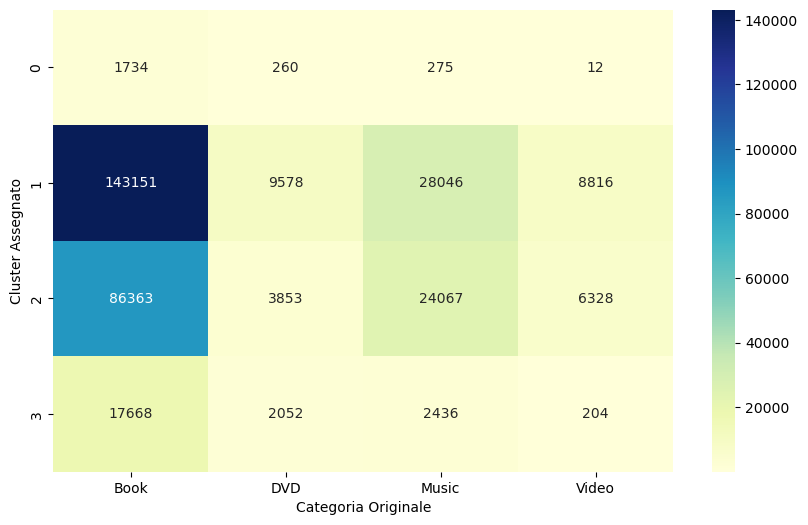

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Categoria Originale')
plt.ylabel('Cluster Assegnato')
plt.show()